# Q1

In [1]:
import sqlite3  # Database library
import pandas as pd  # Data manipulation library

# Connect to the database file
conn = sqlite3.connect("/Users/dadmehr/Codes/Python/Starbucks Data Analyst Code Challenge/Data.sqlite3")

description_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
)

SELECT ProductDescription, COUNT(*) AS Count
FROM MergedTables
GROUP BY ProductDescription;
"""

# MergedTables: This combines LineItemSales with ProductIds by matching on ItemId.
# The query counts occurrences of each ProductDescription.

pd.read_sql_query(description_query, conn)

,ProductDescription,Count
0,None,25262
1,OtherProduct,329123
2,Syrup,27385
3,WaterCup,4962


- **NOTE:** I assumed WaterCup is the "water" question referring to.

In [2]:
water_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
),

OnlyWater AS (
    SELECT *
    FROM MergedTables
    WHERE ProductDescription = 'WaterCup'
    AND POSTransactionId NOT IN (
        SELECT POSTransactionId
        FROM MergedTables
        WHERE ProductDescription != 'WaterCup'
    )
)

SELECT * 
FROM OnlyWater;
"""
# MergedTables: Joins LineItemSales with ProductIds on ItemId.
# OnlyWater: Includes transactions exclusively involving 'WaterCup', excluding any others.

# Data inspection
pd.read_sql_query(water_query, conn)

,FiscalWeekBeginDate,POSTransactionId,ParentItemId,ItemId,ItemQuantity,NetSales,ProductDescription
0,2023-06-05,20230606010379011988,11134422,11134422,1.0,0.0,WaterCup
1,2023-06-12,20230612010379016133,11134422,11134422,1.0,0.0,WaterCup
2,2023-06-12,20230618010379012613,11134422,11134422,1.0,0.0,WaterCup
3,2023-06-19,20230624010379036514,11134422,11134422,1.0,0.0,WaterCup
4,2023-07-24,20230728010379036136,11134422,11134422,1.0,0.0,WaterCup
...,...,...,...,...,...,...,...
564,2023-09-18,20230922010379031956,11015038,11015038,1.0,0.0,WaterCup
565,2023-09-18,20230922010379031956,11015038,11015038,1.0,0.0,WaterCup
566,2023-09-25,20230925010379034138,11015038,11015038,1.0,0.0,WaterCup
567,2023-09-25,20230928010379036423,11015038,11015038,1.0,0.0,WaterCup


In [3]:
only_water = pd.read_sql_query(water_query, conn)

total_transactions = len(only_water["ItemQuantity"])
total_water_units = sum(only_water["ItemQuantity"])
total_revenue = sum(only_water["NetSales"])

print(f"Number of water units is {total_water_units}.")
print(f"Number of transactions with only water(s) is {total_transactions}.")
print(f"Revenue generated is {total_revenue}")

Number of water units is 578.0.
Number of transactions with only water(s) is 569.
Revenue generated is 0.0


**NOTE:**  Note: Revenue generated is 0; yet considered 'purchased'.

# Q2

In [4]:
test_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr ON ls.ItemId = pr.ItemId
)

SELECT *
FROM MergedTables
WHERE POSTransactionId = '20230602010379016623';
"""

pd.read_sql_query(test_query, conn)

,FiscalWeekBeginDate,POSTransactionId,ParentItemId,ItemId,ItemQuantity,NetSales,ProductDescription
0,2023-05-29,20230602010379016623,42,42,1.0,4.75,OtherProduct
1,2023-05-29,20230602010379016623,42,42,1.0,4.75,OtherProduct
2,2023-05-29,20230602010379016623,42,11112911,1.0,0.70,OtherProduct
3,2023-05-29,20230602010379016623,11033163,11033163,1.0,3.45,OtherProduct
4,2023-05-29,20230602010379016623,42,109918,2.0,0.80,Syrup


In [5]:
syrup_query = """
WITH MergedTables AS (
    SELECT ls.*, pr.ProductDescription
    FROM LineItemSales ls
    LEFT JOIN ProductIds pr 
    ON ls.ItemId = pr.ItemId
),

SyrupTransactions AS (
    SELECT ParentItemId, POSTransactionId
    FROM MergedTables
    WHERE ProductDescription = 'Syrup'
),

SyrupParents AS (
    SELECT mt.*
    FROM MergedTables mt
    INNER JOIN SyrupTransactions st
    ON mt.ParentItemId = st.ParentItemId AND mt.ItemId = st.ParentItemId AND mt.POSTransactionId = st.POSTransactionId
),

SyrupDrinks AS (
    SELECT mt.*, sp.ItemQuantity
    FROM MergedTables mt
    JOIN SyrupParents sp 
    ON mt.ParentItemId = sp.ParentItemId AND mt.POSTransactionId = sp.POSTransactionId
), 

SyrupPrice AS (SELECT FiscalWeekBeginDate, POSTransactionId, ParentItemId, ItemQuantity, SUM(NetSales) / ItemQuantity AS AveragePricePerUnit
    FROM SyrupDrinks
    GROUP BY FiscalWeekBeginDate, POSTransactionId, ParentItemId
),
    
SyrupTable AS (SELECT FiscalWeekBeginDate, AVG(AveragePricePerUnit)
    FROM SyrupPrice
    WHERE AveragePricePerUnit > 0
    GROUP BY FiscalWeekBeginDate
)

SELECT *
FROM SyrupTable;

"""


# MergedTables: Joins LineItemSales with ProductIds on ItemId.
# SyrupTransactions: Picks Syrup-related ParentItemId and POSTransactionId.
# SyrupParents: Captures details of Parent Items in Syrup transactions.
# SyrupDrinks: Gathers all items, including Syrup modifications, linked to Syrup ParentItemId.
# SyrupPrice: Calculates total price of drinks, factoring in Syrup modifications, based on parent ItemQuantity.
# SyrupTable: Computes weekly average price of drinks containing syrup.

# Data Inspection: Analyzing the dataset for insights and anomalies.
pd.read_sql_query(syrup_query, conn)

,FiscalWeekBeginDate,AVG(AveragePricePerUnit)
0,2023-05-29,5.731837
1,2023-06-05,6.011053
2,2023-06-12,6.199585
3,2023-06-19,6.457818
4,2023-06-26,6.359449
5,2023-07-03,7.855825
6,2023-07-10,6.343356
7,2023-07-17,5.997492
8,2023-07-24,5.771101
9,2023-07-31,6.889500


- **NOTE:** Parent items identified when `ParentItemId` equals `ItemId`. Analysis focuses on price per parent `ItemQuantity`, acknowledging instances of `ItemQuantity` greater than 1 in the dataset.

- **'WITH' Clause:** Utilized for clearer, more maintainable SQL queries, aiding in debugging and potentially enhancing query efficiency.

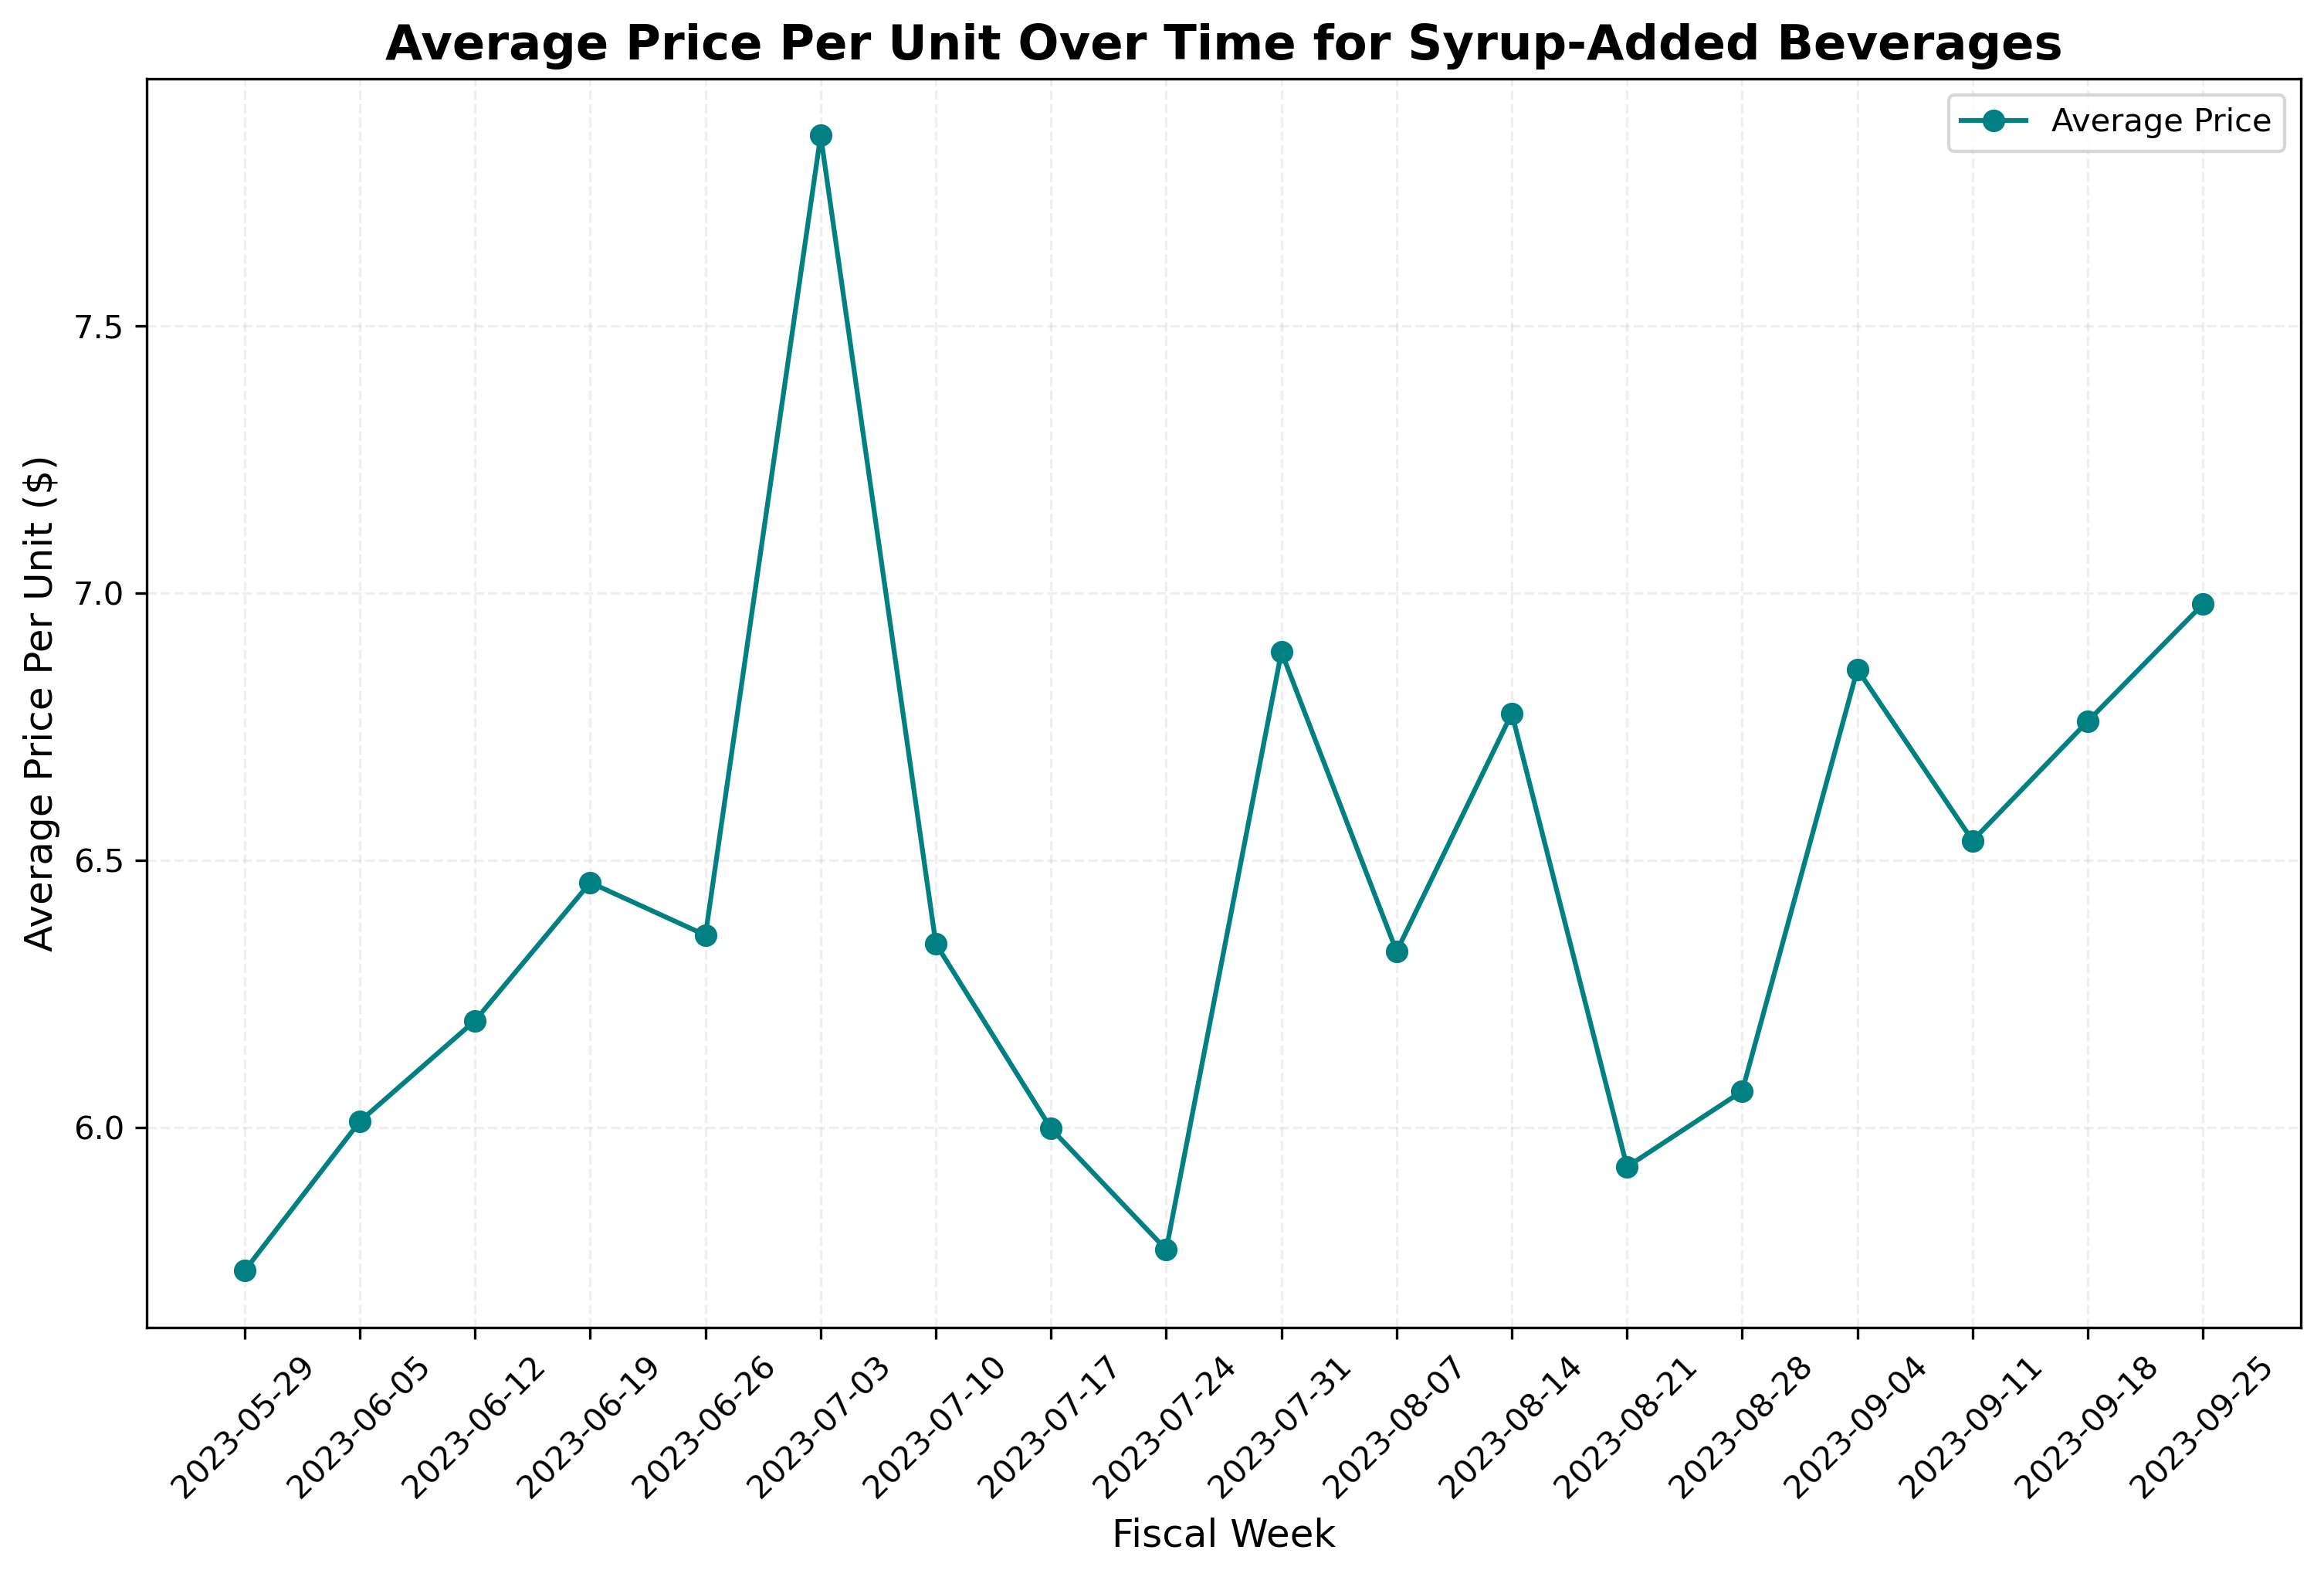

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

syrup_data = pd.read_sql_query(syrup_query, conn)

# Plot the data
plt.figure(figsize=(12, 7), dpi = 300)  # Larger figure size for better visibility
plt.plot(syrup_data['FiscalWeekBeginDate'], syrup_data['AVG(AveragePricePerUnit)'], marker='o', linestyle='-', color='teal', label='Average Price')

# Formatting the plot
plt.title('Average Price Per Unit Over Time for Syrup-Added Beverages', fontsize=15, fontweight='bold')
plt.xlabel('Fiscal Week', fontsize=12)
plt.ylabel('Average Price Per Unit ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.2)  # Lighter grid lines for better readability
plt.legend(loc='upper right')  # Add a legend
plt.show()

- **NOTE:** Average price around $6 looks realistic for a drink with syrup in 2023.

- **NOTE:** Important to decide on including zero-priced items; possibly indicating data inaccuracies. Analysis showed minor differences when excluding zero-priced syrup beverages.